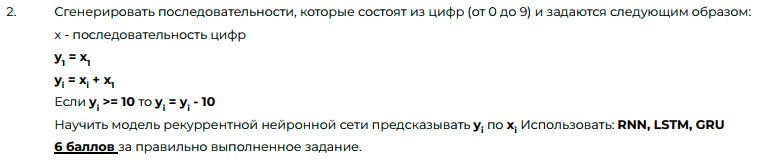

In [1]:
import torch
import time
import tqdm
import random

In [2]:
BATCH_SIZE = 50
TRAIN_STRING_SIZE = 200
TEST_STRING_SIZE = 100
VAL_STRING_SIZE = 50
NUM_EPOCHS = 20
LEARNING_RATE = 1e-3
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
class SentenceDataset():

    def __init__(self):
        super().__init__()

    def generate_dataset(self, sequence_length):
        X = torch.randint(low=0, high=9, size=(sequence_length,), device=DEVICE, dtype=int)
        if X[0].item() == 0:          # to avoid case with X = Y
            X[0] = random.randint(1,9)
        Y = torch.zeros([sequence_length], device=DEVICE, dtype=int)

        for i in range(sequence_length):
            Y[i] = self.get_Y(X[i], X[0])

        return X, Y
        
    def get_Y(self, Xi, X1):
        Yi = Xi + X1
        if Yi >= 10:
            Yi -= 10
        return Yi
    

In [4]:
data = SentenceDataset()

In [5]:
X_full, Y_full =  data.generate_dataset(TRAIN_STRING_SIZE + TEST_STRING_SIZE + VAL_STRING_SIZE)
X_train, Y_train = X_full[:TRAIN_STRING_SIZE], Y_full[:TRAIN_STRING_SIZE]
X_test, Y_test = X_full[TRAIN_STRING_SIZE:TRAIN_STRING_SIZE+TEST_STRING_SIZE], Y_full[TRAIN_STRING_SIZE:TRAIN_STRING_SIZE+TEST_STRING_SIZE]
X_val, Y_val = X_full[TRAIN_STRING_SIZE+TEST_STRING_SIZE:], Y_full[TRAIN_STRING_SIZE+TEST_STRING_SIZE:]

In [6]:
train_dataset = torch.utils.data.TensorDataset(X_train, Y_train)
train_data = torch.utils.data.DataLoader(train_dataset, BATCH_SIZE, shuffle=True)

In [7]:
test_dataset = torch.utils.data.TensorDataset(X_test, Y_test)
test_data = torch.utils.data.DataLoader(test_dataset, BATCH_SIZE, shuffle=False)

# Models (RNN, GRU, LSTM)





In [15]:
# Flexible class RNN to implement different model kind: simple RNN / GRU / LSTM
class RnnFlexModel(torch.nn.Module):

    def __init__(self, rnnClass, model_name, vocab_size, embed_dim, hidden_size):
        super().__init__()
        self.name = model_name
        self.embedding = torch.nn.Embedding(vocab_size, embed_dim)
        self.hidden_size = hidden_size
        self.hidden = rnnClass(embed_dim, hidden_size, batch_first=True)
        self.fc = torch.nn.Linear(hidden_size, vocab_size)

    def forward(self, X):
        embed = self.embedding(X)
        out, hidden = self.hidden(embed)  # LSTM and GRU outputs differ, LSTM should be overrided later
        out = self.fc(out)
        return out, hidden

    def init_hidden(self, batch_size):
        hidden = torch.zeros(1, batch_size, self.hidden_size) # for LSTM cell has to be added
        return hidden

## RNN model

In [16]:
model = RnnFlexModel(torch.nn.RNN, 'RNN', 10, 64, 128).to(DEVICE)

In [17]:
model.name, model

('RNN', RnnFlexModel(
   (embedding): Embedding(10, 64)
   (hidden): RNN(64, 128, batch_first=True)
   (fc): Linear(in_features=128, out_features=10, bias=True)
 ))

In [19]:
loss = torch.nn.CrossEntropyLoss().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [24]:
def train_model(model):

    print("** Training {} model**".format(model.name))

    for epoch in range(NUM_EPOCHS):
        train_loss, train_acc, iter_num = 0., 0., 0.
        start_epoch_time = time.time()
        model.train()
        for x, y in tqdm.tqdm(train_data):
            y = y.view(1, -1).squeeze()
            optimizer.zero_grad()
            out, _ = model(x)
            y_pred = out.argmax(dim=1)
            l = loss(out, y)
            train_loss += l.item()
            batch_acc = (y_pred == y)
            train_acc += batch_acc.sum().item() / batch_acc.shape[0]
            l.backward()
            optimizer.step()
            iter_num += 1
        print(
            f"\tEpoch: {epoch}, loss: {train_loss:.4f}, acc: "
            f"{train_acc / iter_num:.4f}", end=" | "
        )
        test_loss, test_acc, iter_num = 0., 0., 0.
        model.eval()
        for x, y in test_data:
            y = y.view(1, -1).squeeze()
            out, _ = model(x)
            y_pred = out.argmax(dim=1)
            l = loss(out, y)
            test_loss += l.item()
            batch_acc = (y_pred == y)
            test_acc += batch_acc.sum().item() / batch_acc.shape[0]
            iter_num += 1
        print(
            f"test loss: {test_loss:.4f}, test acc: {test_acc / iter_num:.4f} | "
            f"{time.time() - start_epoch_time:.2f} sec"
        )

In [25]:
train_model(model)

** Training RNN model**


100%|██████████| 4/4 [00:00<00:00, 46.92it/s]


	Epoch: 0, loss: 9.1637, acc: 0.1450 | test loss: 3.9943, test acc: 0.4200 | 0.10 sec


100%|██████████| 4/4 [00:00<00:00, 138.06it/s]


	Epoch: 1, loss: 7.2623, acc: 0.8200 | test loss: 3.1639, test acc: 0.9700 | 0.05 sec


100%|██████████| 4/4 [00:00<00:00, 144.22it/s]

	Epoch: 2, loss: 5.6704, acc: 1.0000 | test loss: 2.4360, test acc: 1.0000 | 0.05 sec

100%|██████████| 4/4 [00:00<00:00, 145.63it/s]


	Epoch: 3, loss: 4.3000, acc: 1.0000 | test loss: 1.8378, test acc: 1.0000 | 0.05 sec


100%|██████████| 4/4 [00:00<00:00, 131.64it/s]


	Epoch: 4, loss: 3.1711, acc: 1.0000 | test loss: 1.3585, test acc: 1.0000 | 0.06 sec


100%|██████████| 4/4 [00:00<00:00, 133.03it/s]


	Epoch: 5, loss: 2.2763, acc: 1.0000 | test loss: 0.9911, test acc: 1.0000 | 0.06 sec


100%|██████████| 4/4 [00:00<00:00, 120.71it/s]


	Epoch: 6, loss: 1.6422, acc: 1.0000 | test loss: 0.7183, test acc: 1.0000 | 0.05 sec


100%|██████████| 4/4 [00:00<00:00, 92.84it/s]


	Epoch: 7, loss: 1.1776, acc: 1.0000 | test loss: 0.5235, test acc: 1.0000 | 0.07 sec


100%|██████████| 4/4 [00:00<00:00, 112.07it/s]


	Epoch: 8, loss: 0.8679, acc: 1.0000 | test loss: 0.3894, test acc: 1.0000 | 0.06 sec


100%|██████████| 4/4 [00:00<00:00, 126.71it/s]


	Epoch: 9, loss: 0.6348, acc: 1.0000 | test loss: 0.2956, test acc: 1.0000 | 0.06 sec


100%|██████████| 4/4 [00:00<00:00, 75.44it/s]


	Epoch: 10, loss: 0.4895, acc: 1.0000 | test loss: 0.2310, test acc: 1.0000 | 0.08 sec


100%|██████████| 4/4 [00:00<00:00, 114.43it/s]


	Epoch: 11, loss: 0.3859, acc: 1.0000 | test loss: 0.1851, test acc: 1.0000 | 0.06 sec


100%|██████████| 4/4 [00:00<00:00, 124.64it/s]


	Epoch: 12, loss: 0.3114, acc: 1.0000 | test loss: 0.1519, test acc: 1.0000 | 0.06 sec


100%|██████████| 4/4 [00:00<00:00, 100.66it/s]


	Epoch: 13, loss: 0.2591, acc: 1.0000 | test loss: 0.1278, test acc: 1.0000 | 0.06 sec


100%|██████████| 4/4 [00:00<00:00, 134.47it/s]


	Epoch: 14, loss: 0.2170, acc: 1.0000 | test loss: 0.1095, test acc: 1.0000 | 0.05 sec


100%|██████████| 4/4 [00:00<00:00, 121.97it/s]


	Epoch: 15, loss: 0.1907, acc: 1.0000 | test loss: 0.0955, test acc: 1.0000 | 0.05 sec


100%|██████████| 4/4 [00:00<00:00, 111.65it/s]


	Epoch: 16, loss: 0.1643, acc: 1.0000 | test loss: 0.0845, test acc: 1.0000 | 0.06 sec


100%|██████████| 4/4 [00:00<00:00, 129.25it/s]


	Epoch: 17, loss: 0.1477, acc: 1.0000 | test loss: 0.0757, test acc: 1.0000 | 0.06 sec


100%|██████████| 4/4 [00:00<00:00, 139.16it/s]


	Epoch: 18, loss: 0.1328, acc: 1.0000 | test loss: 0.0685, test acc: 1.0000 | 0.05 sec


100%|██████████| 4/4 [00:00<00:00, 73.10it/s]

	Epoch: 19, loss: 0.1205, acc: 1.0000 | test loss: 0.0625, test acc: 1.0000 | 0.07 sec


In [28]:
def show_validation_result():
    out, _ = model(X_val)
    val_results = out.argmax(dim=1)
    val_acc = (val_results == Y_val).flatten()
    val_acc = (val_acc.sum() / val_acc.shape[0]).item()
    input_sentence = ''.join([str(i.item()) for i in X_val])
    out_sentence = ''.join([str(i.item()) for i in val_results])
    true_sentence = ''.join([str(i.item()) for i in Y_val])

    print(f"Validation accuracy is : {val_acc:.4f}")
    print("-" * (VAL_STRING_SIZE + 30))
    print(f"Input sentence is :     \"{input_sentence}\"")
    print("-" * (VAL_STRING_SIZE + 30))
    print(f"Validation sentence is: \"{out_sentence}\"")
    print("-" * (VAL_STRING_SIZE + 30))
    print(f"True sentence is:       \"{true_sentence}\"")

In [29]:
show_validation_result()

Validation accuracy is : 1.0000
--------------------------------------------------------------------------------
Input sentence is :     "12701365487557654353167574572884025738670264181274"
--------------------------------------------------------------------------------
Validation sentence is: "56145709821991098797501918916228469172014608525618"
--------------------------------------------------------------------------------
True sentence is:       "56145709821991098797501918916228469172014608525618"


## GRU model

In [31]:
model = RnnFlexModel(torch.nn.GRU, 'GRU', 10, 64, 128).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
model.name, model

('GRU', RnnFlexModel(
   (embedding): Embedding(10, 64)
   (hidden): GRU(64, 128, batch_first=True)
   (fc): Linear(in_features=128, out_features=10, bias=True)
 ))

In [32]:
train_model(model)

** Training GRU model**


100%|██████████| 4/4 [00:00<00:00, 48.90it/s]


	Epoch: 0, loss: 9.0009, acc: 0.2350 | test loss: 4.1178, test acc: 0.6600 | 0.11 sec


100%|██████████| 4/4 [00:00<00:00, 62.42it/s]

	Epoch: 1, loss: 7.7987, acc: 0.7400 | 

test loss: 3.6014, test acc: 0.8800 | 0.09 sec


100%|██████████| 4/4 [00:00<00:00, 58.55it/s]


	Epoch: 2, loss: 6.6974, acc: 0.8850 | test loss: 3.0863, test acc: 0.9400 | 0.10 sec


100%|██████████| 4/4 [00:00<00:00, 64.97it/s]


	Epoch: 3, loss: 5.6332, acc: 0.9200 | test loss: 2.5825, test acc: 0.9700 | 0.09 sec


100%|██████████| 4/4 [00:00<00:00, 65.24it/s]


	Epoch: 4, loss: 4.5962, acc: 0.9700 | test loss: 2.0862, test acc: 0.9900 | 0.10 sec


100%|██████████| 4/4 [00:00<00:00, 60.38it/s]


	Epoch: 5, loss: 3.5643, acc: 1.0000 | test loss: 1.6161, test acc: 1.0000 | 0.11 sec


100%|██████████| 4/4 [00:00<00:00, 61.75it/s]


	Epoch: 6, loss: 2.6287, acc: 1.0000 | test loss: 1.2032, test acc: 1.0000 | 0.09 sec


100%|██████████| 4/4 [00:00<00:00, 52.44it/s]


	Epoch: 7, loss: 1.8902, acc: 1.0000 | test loss: 0.8599, test acc: 1.0000 | 0.10 sec


100%|██████████| 4/4 [00:00<00:00, 59.64it/s]


	Epoch: 8, loss: 1.3033, acc: 1.0000 | test loss: 0.5960, test acc: 1.0000 | 0.11 sec


100%|██████████| 4/4 [00:00<00:00, 59.47it/s]


	Epoch: 9, loss: 0.8811, acc: 1.0000 | test loss: 0.4091, test acc: 1.0000 | 0.09 sec


100%|██████████| 4/4 [00:00<00:00, 49.43it/s]

	Epoch: 10, loss: 0.6236, acc: 1.0000 | 

test loss: 0.2874, test acc: 1.0000 | 0.11 sec


100%|██████████| 4/4 [00:00<00:00, 59.89it/s]


	Epoch: 11, loss: 0.4298, acc: 1.0000 | test loss: 0.2083, test acc: 1.0000 | 0.10 sec


100%|██████████| 4/4 [00:00<00:00, 65.14it/s]


	Epoch: 12, loss: 0.3234, acc: 1.0000 | test loss: 0.1570, test acc: 1.0000 | 0.10 sec


100%|██████████| 4/4 [00:00<00:00, 64.47it/s]


	Epoch: 13, loss: 0.2413, acc: 1.0000 | test loss: 0.1230, test acc: 1.0000 | 0.09 sec


100%|██████████| 4/4 [00:00<00:00, 64.90it/s]


	Epoch: 14, loss: 0.1897, acc: 1.0000 | test loss: 0.0999, test acc: 1.0000 | 0.09 sec


100%|██████████| 4/4 [00:00<00:00, 59.99it/s]


	Epoch: 15, loss: 0.1601, acc: 1.0000 | test loss: 0.0833, test acc: 1.0000 | 0.09 sec


100%|██████████| 4/4 [00:00<00:00, 62.65it/s]


	Epoch: 16, loss: 0.1335, acc: 1.0000 | test loss: 0.0713, test acc: 1.0000 | 0.10 sec


100%|██████████| 4/4 [00:00<00:00, 54.10it/s]


	Epoch: 17, loss: 0.1156, acc: 1.0000 | test loss: 0.0625, test acc: 1.0000 | 0.11 sec


100%|██████████| 4/4 [00:00<00:00, 60.77it/s]


	Epoch: 18, loss: 0.0979, acc: 1.0000 | test loss: 0.0557, test acc: 1.0000 | 0.09 sec


100%|██████████| 4/4 [00:00<00:00, 66.15it/s]


	Epoch: 19, loss: 0.0920, acc: 1.0000 | test loss: 0.0502, test acc: 1.0000 | 0.10 sec


In [33]:
show_validation_result()

Validation accuracy is : 1.0000
--------------------------------------------------------------------------------
Input sentence is :     "12701365487557654353167574572884025738670264181274"
--------------------------------------------------------------------------------
Validation sentence is: "56145709821991098797501918916228469172014608525618"
--------------------------------------------------------------------------------
True sentence is:       "56145709821991098797501918916228469172014608525618"


## LSTM model

In [34]:
class LstmModel(RnnFlexModel):

    def __init__(self, rnnClass, model_name, vocab_size, embed_dim, hidden_size):
        super().__init__(self, rnnClass, model_name, vocab_size, embed_dim, hidden_size)

    def forward(self, X):
        out = self.embedding(X)
        out, (hidden, cell) = self.hidden(out, (hidden, cell))
        out = self.linear(out)
        return out, (hidden, cell)

    def init_hidden(self, batch_size):
        hidden = torch.zeros(1, batch_size, self.hidden_size)
        cell = torch.zeros(1, batch_size, self.hidden_size)
        return hidden, cell


In [35]:
model = RnnFlexModel(torch.nn.LSTM, 'LSTM', 10, 64, 128).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
model.name, model

('LSTM', RnnFlexModel(
   (embedding): Embedding(10, 64)
   (hidden): LSTM(64, 128, batch_first=True)
   (fc): Linear(in_features=128, out_features=10, bias=True)
 ))

In [36]:
train_model(model)

** Training LSTM model**


100%|██████████| 4/4 [00:00<00:00, 45.49it/s]


	Epoch: 0, loss: 8.9870, acc: 0.2600 | test loss: 4.3008, test acc: 0.4700 | 0.12 sec


100%|██████████| 4/4 [00:00<00:00, 44.55it/s]


	Epoch: 1, loss: 8.3100, acc: 0.6800 | test loss: 3.9736, test acc: 0.8100 | 0.12 sec


100%|██████████| 4/4 [00:00<00:00, 46.40it/s]


	Epoch: 2, loss: 7.6088, acc: 0.8700 | test loss: 3.6251, test acc: 0.9100 | 0.11 sec


100%|██████████| 4/4 [00:00<00:00, 50.43it/s]


	Epoch: 3, loss: 6.9071, acc: 0.9050 | test loss: 3.2425, test acc: 0.9200 | 0.11 sec


100%|██████████| 4/4 [00:00<00:00, 48.43it/s]


	Epoch: 4, loss: 6.0530, acc: 0.9050 | test loss: 2.8332, test acc: 0.8900 | 0.11 sec


100%|██████████| 4/4 [00:00<00:00, 54.81it/s]


	Epoch: 5, loss: 5.2264, acc: 0.9100 | test loss: 2.4165, test acc: 0.9200 | 0.10 sec


100%|██████████| 4/4 [00:00<00:00, 63.65it/s]


	Epoch: 6, loss: 4.4070, acc: 0.9500 | test loss: 1.9583, test acc: 0.9900 | 0.09 sec


100%|██████████| 4/4 [00:00<00:00, 67.76it/s]


	Epoch: 7, loss: 3.4538, acc: 0.9950 | test loss: 1.5141, test acc: 1.0000 | 0.09 sec


100%|██████████| 4/4 [00:00<00:00, 54.06it/s]


	Epoch: 8, loss: 2.6199, acc: 1.0000 | test loss: 1.1332, test acc: 1.0000 | 0.10 sec


100%|██████████| 4/4 [00:00<00:00, 62.93it/s]


	Epoch: 9, loss: 1.8996, acc: 1.0000 | test loss: 0.8235, test acc: 1.0000 | 0.09 sec


100%|██████████| 4/4 [00:00<00:00, 59.96it/s]


	Epoch: 10, loss: 1.4177, acc: 1.0000 | test loss: 0.5912, test acc: 1.0000 | 0.10 sec


100%|██████████| 4/4 [00:00<00:00, 47.35it/s]

	Epoch: 11, loss: 0.9812, acc: 1.0000 | 

test loss: 0.4299, test acc: 1.0000 | 0.11 sec


100%|██████████| 4/4 [00:00<00:00, 57.47it/s]

	Epoch: 12, loss: 0.7179, acc: 1.0000 | 

test loss: 0.3190, test acc: 1.0000 | 0.10 sec


100%|██████████| 4/4 [00:00<00:00, 57.06it/s]


	Epoch: 13, loss: 0.5364, acc: 1.0000 | test loss: 0.2439, test acc: 1.0000 | 0.10 sec


100%|██████████| 4/4 [00:00<00:00, 55.46it/s]


	Epoch: 14, loss: 0.4129, acc: 1.0000 | test loss: 0.1919, test acc: 1.0000 | 0.10 sec


100%|██████████| 4/4 [00:00<00:00, 61.52it/s]


	Epoch: 15, loss: 0.3389, acc: 1.0000 | test loss: 0.1554, test acc: 1.0000 | 0.10 sec


100%|██████████| 4/4 [00:00<00:00, 55.71it/s]


	Epoch: 16, loss: 0.2698, acc: 1.0000 | test loss: 0.1298, test acc: 1.0000 | 0.10 sec


100%|██████████| 4/4 [00:00<00:00, 52.79it/s]

	Epoch: 17, loss: 0.2235, acc: 1.0000 | test loss: 0.1110, test acc: 1.0000 | 0.10 sec

100%|██████████| 4/4 [00:00<00:00, 48.97it/s]

	Epoch: 18, loss: 0.1911, acc: 1.0000 | 

test loss: 0.0968, test acc: 1.0000 | 0.11 sec


100%|██████████| 4/4 [00:00<00:00, 59.54it/s]

	Epoch: 19, loss: 0.1745, acc: 1.0000 | 

test loss: 0.0859, test acc: 1.0000 | 0.10 sec


In [37]:
show_validation_result()

Validation accuracy is : 1.0000
--------------------------------------------------------------------------------
Input sentence is :     "12701365487557654353167574572884025738670264181274"
--------------------------------------------------------------------------------
Validation sentence is: "56145709821991098797501918916228469172014608525618"
--------------------------------------------------------------------------------
True sentence is:       "56145709821991098797501918916228469172014608525618"
